# In this notebook we did:
  - Evaluates models on a pancancer dataset of 1477 samples and 1463 proteins (blood cancer types combined).
  - Missing values handled using KNN imputation.
  - SMOTE applied for data balancing within each fold.
  - Random Forest and Extra Trees Classifiers performed.
  - k-Fold Cross-Validation is used to assess model performance.
  - Performance metrics: accuracy, F1 score (weighted), and ROC AUC.
  - The entire process (imputation, SMOTE, classification) is encapsulated in a machine learning pipeline

In [30]:
# Import the packages we may need
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from seaborn import set_style
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import is_classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.utils import resample
from sklearn.multiclass import OneVsRestClassifier  # Correct location for OneVsRestClassifier
from scipy.stats import sem
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline  # Use imblearn's pipeline instead of sklearn



In [31]:
#Random forest for feature importances
from sklearn.tree import DecisionTreeClassifier


## This sets the plot style
## to have a grid on a white background
set_style("whitegrid")


In [32]:
df_full = pd.read_csv('pancancer.csv')
df_full

,Sample_ID,Cancer,Assay,OlinkID,UniProt,Panel,NPX
0,AML_1,AML,AARSD1,OID21311,Q9BTE6,Oncology,5.01745
1,AML_2,AML,AARSD1,OID21311,Q9BTE6,Oncology,2.86790
2,AML_3,AML,AARSD1,OID21311,Q9BTE6,Oncology,4.58825
3,AML_4,AML,AARSD1,OID21311,Q9BTE6,Oncology,1.97255
4,AML_5,AML,AARSD1,OID21311,Q9BTE6,Oncology,3.45995
...,...,...,...,...,...,...,...
2082004,PRC_157,PRC,ZBTB17,OID20082,Q13105,Cardiometabolic,0.99695
2082005,PRC_159,PRC,ZBTB17,OID20082,Q13105,Cardiometabolic,1.12060
2082006,PRC_160,PRC,ZBTB17,OID20082,Q13105,Cardiometabolic,1.61685
2082007,PRC_161,PRC,ZBTB17,OID20082,Q13105,Cardiometabolic,0.91665


In [33]:
#df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
#df

In [34]:
# Confirm that there are 49 proteins in the shortened dataset
len(set(df_full['UniProt']))

1463

In [35]:
print(df_full['Cancer'].unique())

['AML' 'BRC' 'CVX' 'CLL' 'CRC' 'LYMPH' 'ENDC' 'GLIOM' 'LUNGC' 'MYEL' 'OVC'
 'PRC']


In [36]:
# Combine all the blood cancers into one category
df_bloodcombined = df_full.copy(deep = True)
df_bloodcombined=df_bloodcombined.replace(to_replace = ['AML', 'CLL', 'LYMPH', 'MYEL'], value = 'BLOOD' )
#df_bloodcombined = df_bloodcombined[df_bloodcombined['Cancer'] != 'Ctrl'] #Exclude the control group Ctrl

In [37]:
# Verify that the groups were combined as expected
set(df_bloodcombined['Cancer'])

{'BLOOD', 'BRC', 'CRC', 'CVX', 'ENDC', 'GLIOM', 'LUNGC', 'OVC', 'PRC'}

In [38]:
# Create a pivot table that makes each sample a row, and includes the data for each protein in a column

Pancancer_pivot = df_full.pivot_table(index = ['Sample_ID', 'Cancer'], columns = 'UniProt', values = 'NPX' )
Pancancer_pivot.reset_index(inplace=True)
Pancancer_pivot

UniProt,Sample_ID,Cancer,A1E959,A1L4H1,A4D1B5,A6NI73,B1AKI9,NTproBNP,O00161,O00175,...,Q9Y653,Q9Y662,Q9Y680,Q9Y6A5,Q9Y6D9,Q9Y6E0,Q9Y6K9,Q9Y6N7,Q9Y6Q6,Q9Y6Y9
0,AML_1,AML,0.59590,0.87345,0.40330,-0.21795,0.97590,-0.04425,5.97330,0.03015,...,1.52805,2.40925,2.58555,7.69330,4.32885,3.46615,4.93360,-0.01040,0.32665,0.95790
1,AML_10,AML,0.15515,1.03055,NaN,0.50050,0.87950,3.61830,1.29445,-0.08635,...,0.61565,1.79640,-0.48390,1.79995,2.66910,0.94350,2.44435,-0.00260,0.74770,0.51200
2,AML_11,AML,0.90720,0.67170,0.13230,0.24330,0.42020,0.02195,3.52340,1.58670,...,0.83225,1.19945,0.90375,3.98285,0.60025,2.04640,2.24825,0.10105,1.93530,0.65845
3,AML_12,AML,0.89270,0.65435,0.40980,NaN,0.00695,NaN,NaN,1.07615,...,1.64900,1.85145,-0.06600,0.43480,NaN,0.83995,1.19885,0.19860,0.49505,NaN
4,AML_13,AML,0.21820,0.67290,-0.02685,-1.16925,1.12230,2.02365,4.21855,-0.49085,...,1.66665,2.16280,2.03590,6.10880,4.36115,2.25940,4.29675,0.57890,1.06285,0.49960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472,PRC_95,PRC,-0.07995,1.17485,-0.50350,0.22020,1.11440,0.43975,3.50905,NaN,...,3.74495,1.42110,0.62870,5.56515,1.09790,1.73780,3.22705,NaN,1.11260,1.17645
1473,PRC_96,PRC,0.10865,1.36215,-1.39700,0.59710,0.79345,-0.22915,3.24765,1.82880,...,0.56030,0.87690,0.20290,4.33985,0.01350,1.09710,1.59750,0.06615,0.27285,0.04120
1474,PRC_97,PRC,1.10440,0.83665,-0.59465,0.58255,2.27605,2.86510,4.98215,1.42610,...,4.14455,1.40945,0.73375,6.54120,1.54650,2.76870,4.43180,1.22940,1.58205,1.18800
1475,PRC_98,PRC,0.67550,0.99775,-0.12945,0.01475,0.19045,-1.20325,5.97455,0.10410,...,1.36740,1.38990,2.73540,8.40185,2.67285,3.52630,4.11800,0.40570,0.93575,0.69800


In [10]:
# Combine all the blood cancers into one category
df_bloodcombined = Pancancer_pivot.copy(deep = True)
df_bloodcombined=df_bloodcombined.replace(to_replace = ['AML', 'CLL', 'LYMPH', 'MYEL'], value = 'BLOOD' )
#df_bloodcombined = df_bloodcombined[df_bloodcombined['Cancer'] != 'Ctrl'] #Exclude the control group Ctrl

In [11]:
# Export the cleaned data as a csv file
Pancancer_pivot.to_csv('pancancer_full_pivot.csv', index = False)

In [12]:
# Specify the protein list 
proteins=df_bloodcombined.columns[2:]
# Check that we have the right number of proteins
len(proteins)

1463

In [13]:
df_bloodcombined.head()

UniProt,Sample_ID,Cancer,A1E959,A1L4H1,A4D1B5,A6NI73,B1AKI9,NTproBNP,O00161,O00175,...,Q9Y653,Q9Y662,Q9Y680,Q9Y6A5,Q9Y6D9,Q9Y6E0,Q9Y6K9,Q9Y6N7,Q9Y6Q6,Q9Y6Y9
0,AML_1,BLOOD,0.59590,0.87345,0.40330,-0.21795,0.97590,-0.04425,5.97330,0.03015,...,1.52805,2.40925,2.58555,7.69330,4.32885,3.46615,4.93360,-0.01040,0.32665,0.95790
1,AML_10,BLOOD,0.15515,1.03055,NaN,0.50050,0.87950,3.61830,1.29445,-0.08635,...,0.61565,1.79640,-0.48390,1.79995,2.66910,0.94350,2.44435,-0.00260,0.74770,0.51200
2,AML_11,BLOOD,0.90720,0.67170,0.13230,0.24330,0.42020,0.02195,3.52340,1.58670,...,0.83225,1.19945,0.90375,3.98285,0.60025,2.04640,2.24825,0.10105,1.93530,0.65845
3,AML_12,BLOOD,0.89270,0.65435,0.40980,NaN,0.00695,NaN,NaN,1.07615,...,1.64900,1.85145,-0.06600,0.43480,NaN,0.83995,1.19885,0.19860,0.49505,NaN
4,AML_13,BLOOD,0.21820,0.67290,-0.02685,-1.16925,1.12230,2.02365,4.21855,-0.49085,...,1.66665,2.16280,2.03590,6.10880,4.36115,2.25940,4.29675,0.57890,1.06285,0.49960


In [14]:
# Verify that the groups were combined as expected
set(df_bloodcombined['Cancer'])

{'BLOOD', 'BRC', 'CRC', 'CVX', 'ENDC', 'GLIOM', 'LUNGC', 'OVC', 'PRC'}

In [15]:
# Encode the cancer types as numbers

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_bloodcombined['Cancer'] = le.fit_transform(df_bloodcombined['Cancer'])

In [16]:
df_bloodcombined.head(15)

UniProt,Sample_ID,Cancer,A1E959,A1L4H1,A4D1B5,A6NI73,B1AKI9,NTproBNP,O00161,O00175,...,Q9Y653,Q9Y662,Q9Y680,Q9Y6A5,Q9Y6D9,Q9Y6E0,Q9Y6K9,Q9Y6N7,Q9Y6Q6,Q9Y6Y9
0,AML_1,0,0.59590,0.87345,0.40330,-0.21795,0.97590,-0.04425,5.97330,0.03015,...,1.52805,2.40925,2.58555,7.69330,4.32885,3.46615,4.93360,-0.01040,0.32665,0.95790
1,AML_10,0,0.15515,1.03055,NaN,0.50050,0.87950,3.61830,1.29445,-0.08635,...,0.61565,1.79640,-0.48390,1.79995,2.66910,0.94350,2.44435,-0.00260,0.74770,0.51200
2,AML_11,0,0.90720,0.67170,0.13230,0.24330,0.42020,0.02195,3.52340,1.58670,...,0.83225,1.19945,0.90375,3.98285,0.60025,2.04640,2.24825,0.10105,1.93530,0.65845
3,AML_12,0,0.89270,0.65435,0.40980,NaN,0.00695,NaN,NaN,1.07615,...,1.64900,1.85145,-0.06600,0.43480,NaN,0.83995,1.19885,0.19860,0.49505,NaN
4,AML_13,0,0.21820,0.67290,-0.02685,-1.16925,1.12230,2.02365,4.21855,-0.49085,...,1.66665,2.16280,2.03590,6.10880,4.36115,2.25940,4.29675,0.57890,1.06285,0.49960
5,AML_14,0,0.08920,0.22545,-0.47415,1.83150,0.92420,6.56080,4.30555,0.92640,...,5.56885,2.46510,1.82050,6.14920,5.99445,1.44280,5.41060,0.41685,3.25440,1.09110
6,AML_15,0,-0.07185,0.10130,-1.39720,3.05240,1.26085,5.36945,1.55795,2.40705,...,1.48585,2.23725,0.15615,2.42300,4.81290,0.49115,2.69765,0.45220,1.49335,1.31605
7,AML_16,0,0.64490,-0.00030,-1.52450,0.76560,1.11520,1.03430,0.93625,2.18410,...,2.53005,1.27950,-0.38825,0.62780,2.90270,0.30915,1.44680,0.46245,1.34865,0.24400
8,AML_17,0,0.11200,0.84130,-0.81540,0.51790,2.04955,1.60310,3.77460,-0.22100,...,NaN,NaN,1.16780,NaN,NaN,1.61305,2.62540,0.03750,2.35580,NaN
9,AML_18,0,0.97170,0.61700,-1.53600,0.22060,1.15250,1.96905,-0.01260,3.56180,...,3.79465,1.84825,0.11195,0.87955,3.94285,-0.40650,1.03135,0.24875,2.67350,1.88915


In [17]:
# Split the data into X and y
X = df_bloodcombined[proteins]
y = df_bloodcombined['Cancer']

In [18]:
X.head()

UniProt,A1E959,A1L4H1,A4D1B5,A6NI73,B1AKI9,NTproBNP,O00161,O00175,O00182,O00186,...,Q9Y653,Q9Y662,Q9Y680,Q9Y6A5,Q9Y6D9,Q9Y6E0,Q9Y6K9,Q9Y6N7,Q9Y6Q6,Q9Y6Y9
0,0.59590,0.87345,0.40330,-0.21795,0.97590,-0.04425,5.97330,0.03015,1.59230,2.19040,...,1.52805,2.40925,2.58555,7.69330,4.32885,3.46615,4.93360,-0.01040,0.32665,0.95790
1,0.15515,1.03055,NaN,0.50050,0.87950,3.61830,1.29445,-0.08635,1.16670,NaN,...,0.61565,1.79640,-0.48390,1.79995,2.66910,0.94350,2.44435,-0.00260,0.74770,0.51200
2,0.90720,0.67170,0.13230,0.24330,0.42020,0.02195,3.52340,1.58670,1.41675,1.16275,...,0.83225,1.19945,0.90375,3.98285,0.60025,2.04640,2.24825,0.10105,1.93530,0.65845
3,0.89270,0.65435,0.40980,NaN,0.00695,NaN,NaN,1.07615,0.98105,0.65770,...,1.64900,1.85145,-0.06600,0.43480,NaN,0.83995,1.19885,0.19860,0.49505,NaN
4,0.21820,0.67290,-0.02685,-1.16925,1.12230,2.02365,4.21855,-0.49085,2.13880,1.47010,...,1.66665,2.16280,2.03590,6.10880,4.36115,2.25940,4.29675,0.57890,1.06285,0.49960


In [19]:
# Split data into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, stratify = y, test_size=0.2, random_state=100)

In [20]:
# Initialize models
models = {
    #"Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=100, solver='lbfgs')),
    #"k-Nearest Neighbors (n=5)": KNeighborsClassifier(n_neighbors=5),
    #"k-Nearest Neighbors (n=13)": KNeighborsClassifier(n_neighbors=13),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=100),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=100),
    #"XGBoost": XGBClassifier(n_estimators=100)
}

In [21]:
# Cross-validation and bootstrapping parameters
n_splits = 5  # Number of folds
n_bootstraps = 1000  # Number of bootstraps for confidence interval calculation
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)



In [139]:
#removed bootstrap to run the code faster non-pipeline
# Loop over models
for model_name, model in models.items():
    #print(f"\nEvaluating {model_name} full pancancer dataset with 1463 proteins")
    print(f"\033[1m\nEvaluating {model_name} full pancancer dataset with all 1463 proteins (combined BLOOD)\033[0m")

    
    
    # Initialize KNNImputer for handling missing values
    imputer = KNNImputer(n_neighbors=5, weights="uniform")
    
    # Containers for accuracy and other metrics
    fold_accuracies = []
    fold_f1_scores = []
    fold_roc_auc_scores = []
    fold_confusion_matrices = []

    # k-Fold Cross-Validation Loop
    for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        # Extract train and test sets for the current fold
        X_fold_train = X_train.iloc[train_index]
        X_fold_test = X_train.iloc[test_index]
        y_fold_train = y_train.iloc[train_index]
        y_fold_test = y_train.iloc[test_index]

        # Apply KNN Imputer to impute missing values for each fold
        X_fold_train_imputed = imputer.fit_transform(X_fold_train)
        X_fold_test_imputed = imputer.transform(X_fold_test)

        # Apply SMOTE to balance the data within each fold
        smote = SMOTE(random_state=100)
        X_resampled, y_resampled = smote.fit_resample(X_fold_train_imputed, y_fold_train)

        # Train the model on the bootstrap sample
        model.fit(X_resampled, y_resampled)

        # Predict and evaluate metrics for this fold
        y_pred = model.predict(X_fold_test_imputed)
        fold_accuracies.append(accuracy_score(y_fold_test, y_pred))
        fold_f1_scores.append(f1_score(y_fold_test, y_pred, average='weighted'))
        fold_roc_auc_scores.append(roc_auc_score(y_fold_test, model.predict_proba(X_fold_test_imputed), multi_class='ovr'))
        fold_confusion_matrices.append(confusion_matrix(y_fold_test, y_pred))

        # Print accuracy and other metrics for this fold
        print(f"Fold {i+1} - Accuracy: {fold_accuracies[-1]:.4f}, F1: {fold_f1_scores[-1]:.4f}, ROC AUC: {fold_roc_auc_scores[-1]:.4f}")
      
        ## Plot the confusion matrix as a heatmap
        #plt.figure(figsize=(8, 6))
        #sns.heatmap(fold_confusion_matrices[-1], annot=True, fmt='d', cmap='Blues', 
        #            xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
        #plt.xlabel('Predicted Label')
        #plt.ylabel('True Label')
        #plt.title(f"Logistic Regression - Fold {i+1} Confusion Matrix")
        #plt.show()
    
    
    # Display averaged accuracy and metrics for the cross-validation
    mean_accuracy = np.mean(fold_accuracies)
    mean_f1_score = np.mean(fold_f1_scores)
    mean_roc_auc = np.mean(fold_roc_auc_scores)
    confidence_interval = 1.96 * sem(fold_accuracies)
    
    print(f"\n{model_name} - Mean Accuracy: {mean_accuracy:.4f} ± {confidence_interval:.4f}")
    print(f"{model_name} - Mean F1 Score: {mean_f1_score:.4f}")
    print(f"{model_name} - Mean ROC AUC: {mean_roc_auc:.4f}")

    ## You could plot the confusion matrix for the last fold
    #plt.figure(figsize=(8, 6))
    #sns.heatmap(fold_confusion_matrices[-1], annot=True, fmt='d', cmap='Blues', 
    #            xticklabels=le.classes_, yticklabels=le.classes_)
    #plt.xlabel('Predicted Label')
    #plt.ylabel('True Label')
    #plt.title(f"{model_name} - Confusion Matrix (Fold {n_splits})")
    #plt.show()

# After cross-validation, we impute on the entire training and test set and train the best model

# Assuming the best model was Random Forest (or another model if selected)
best_model = RandomForestClassifier(n_estimators=100, random_state=100)
imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Impute on entire training set
X_train_imputed = imputer.fit_transform(X_train)

# Impute on the test set (do not fit the imputer again, avoid data leakage)
X_test_imputed = imputer.transform(X_test)

# Train on entire training set
best_model.fit(X_train_imputed, y_train)

# Evaluate on test set
y_test_pred = best_model.predict(X_test_imputed)

# Evaluate final performance metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred, average='weighted')
test_roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test_imputed), multi_class='ovr')

print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test F1 Score: {test_f1_score:.4f}")
print(f"Final Test ROC AUC: {test_roc_auc:.4f}")



Evaluating Random Forest full pancancer dataset with all 1463 proteins (combined BLOOD)
Fold 1 - Accuracy: 0.6793, F1: 0.6805, ROC AUC: 0.9337
Fold 2 - Accuracy: 0.6102, F1: 0.6069, ROC AUC: 0.9034
Fold 3 - Accuracy: 0.6737, F1: 0.6758, ROC AUC: 0.9245
Fold 4 - Accuracy: 0.6483, F1: 0.6460, ROC AUC: 0.9136
Fold 5 - Accuracy: 0.6525, F1: 0.6588, ROC AUC: 0.9192

Random Forest - Mean Accuracy: 0.6528 ± 0.0239
Random Forest - Mean F1 Score: 0.6536
Random Forest - Mean ROC AUC: 0.9189

Evaluating Extra Trees full pancancer dataset with all 1463 proteins (combined BLOOD)
Fold 1 - Accuracy: 0.6203, F1: 0.6226, ROC AUC: 0.9043
Fold 2 - Accuracy: 0.5890, F1: 0.5873, ROC AUC: 0.8858
Fold 3 - Accuracy: 0.6144, F1: 0.6162, ROC AUC: 0.9182
Fold 4 - Accuracy: 0.6059, F1: 0.6105, ROC AUC: 0.9002
Fold 5 - Accuracy: 0.6186, F1: 0.6227, ROC AUC: 0.9060

Extra Trees - Mean Accuracy: 0.6096 ± 0.0112
Extra Trees - Mean F1 Score: 0.6119
Extra Trees - Mean ROC AUC: 0.9029

Final Test Accuracy: 0.6858
Final

In [138]:
#using pipeline structure for imputation and SMOTE

from imblearn.pipeline import Pipeline  # Use imblearn's pipeline

# Loop over models
for model_name, model in models.items():
    print(f"\033[1m\nEvaluating {model_name} full pancancer dataset with all 1463 proteins (combined BLOOD)\033[0m")

    # Container for metrics
    fold_accuracies = []
    fold_f1_scores = []
    fold_roc_auc_scores = []
    fold_confusion_matrices = []

    # k-Fold Cross-Validation Loop
    for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        # Extract train and test sets for the current fold
        X_fold_train = X_train.iloc[train_index]
        X_fold_test = X_train.iloc[test_index]
        y_fold_train = y_train.iloc[train_index]
        y_fold_test = y_train.iloc[test_index]

        # Create the pipeline: Imputation -> SMOTE -> Classifier
        pipeline = Pipeline([
            ('imputer', KNNImputer(n_neighbors=5, weights="uniform")),  # kNN Imputation
            ('smote', SMOTE(random_state=100)),                        # SMOTE
            ('classifier', model)                                       # Model
        ])
        
        # Fit and evaluate the model within the pipeline
        pipeline.fit(X_fold_train, y_fold_train)

        # Predict and evaluate metrics for this fold
        y_pred = pipeline.predict(X_fold_test)
        fold_accuracies.append(accuracy_score(y_fold_test, y_pred))
        fold_f1_scores.append(f1_score(y_fold_test, y_pred, average='weighted'))
        fold_roc_auc_scores.append(roc_auc_score(y_fold_test, pipeline.predict_proba(X_fold_test), multi_class='ovr'))
        fold_confusion_matrices.append(confusion_matrix(y_fold_test, y_pred))

        # Print accuracy and other metrics for this fold
        print(f"Fold {i+1} - Accuracy: {fold_accuracies[-1]:.4f}, F1: {fold_f1_scores[-1]:.4f}, ROC AUC: {fold_roc_auc_scores[-1]:.4f}")

    # Display averaged accuracy and metrics for the cross-validation
    mean_accuracy = np.mean(fold_accuracies)
    mean_f1_score = np.mean(fold_f1_scores)
    mean_roc_auc = np.mean(fold_roc_auc_scores)
    confidence_interval = 1.96 * sem(fold_accuracies)
    
    print(f"\n{model_name} - Mean Accuracy: {mean_accuracy:.4f} ± {confidence_interval:.4f}")
    print(f"{model_name} - Mean F1 Score: {mean_f1_score:.4f}")
    print(f"{model_name} - Mean ROC AUC: {mean_roc_auc:.4f}")

    ## Optionally plot the confusion matrix for the last fold
    #plt.figure(figsize=(8, 6))
    #sns.heatmap(fold_confusion_matrices[-1], annot=True, fmt='d', cmap='Blues', 
    #            xticklabels=le.classes_, yticklabels=le.classes_)
    #plt.xlabel('Predicted Label')
    #plt.ylabel('True Label')
    #plt.title(f"{model_name} - Confusion Matrix (Fold {n_splits})")
    #plt.show()

# After cross-validation, impute on the entire training and test set and train the best model

# Assuming the best model was Random Forest (or another model if selected)
best_model = RandomForestClassifier(n_estimators=100, random_state=100)

# Create the pipeline for final training
pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5, weights="uniform")),
    ('smote', SMOTE(random_state=100)),
    ('classifier', best_model)
])

# Fit the pipeline on the entire training set
pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_test_pred = pipeline.predict(X_test)

# Evaluate final performance metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred, average='weighted')
test_roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test), multi_class='ovr')

print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test F1 Score: {test_f1_score:.4f}")
print(f"Final Test ROC AUC: {test_roc_auc:.4f}")



Evaluating Random Forest full pancancer dataset with all 1463 proteins (combined BLOOD)
Fold 1 - Accuracy: 0.6793, F1: 0.6805, ROC AUC: 0.9337
Fold 2 - Accuracy: 0.6102, F1: 0.6069, ROC AUC: 0.9034
Fold 3 - Accuracy: 0.6737, F1: 0.6758, ROC AUC: 0.9245
Fold 4 - Accuracy: 0.6483, F1: 0.6460, ROC AUC: 0.9136
Fold 5 - Accuracy: 0.6525, F1: 0.6588, ROC AUC: 0.9192

Random Forest - Mean Accuracy: 0.6528 ± 0.0239
Random Forest - Mean F1 Score: 0.6536
Random Forest - Mean ROC AUC: 0.9189

Evaluating Extra Trees full pancancer dataset with all 1463 proteins (combined BLOOD)
Fold 1 - Accuracy: 0.6203, F1: 0.6226, ROC AUC: 0.9043
Fold 2 - Accuracy: 0.5890, F1: 0.5873, ROC AUC: 0.8858
Fold 3 - Accuracy: 0.6144, F1: 0.6162, ROC AUC: 0.9182
Fold 4 - Accuracy: 0.6059, F1: 0.6105, ROC AUC: 0.9002
Fold 5 - Accuracy: 0.6186, F1: 0.6227, ROC AUC: 0.9060

Extra Trees - Mean Accuracy: 0.6096 ± 0.0112
Extra Trees - Mean F1 Score: 0.6119
Extra Trees - Mean ROC AUC: 0.9029

Final Test Accuracy: 0.6689
Final


Evaluating Random Forest full pancancer dataset with all 1463 proteins (combined BLOOD)
Fold 1 - Accuracy: 0.6793, F1: 0.6805, ROC AUC: 0.9337


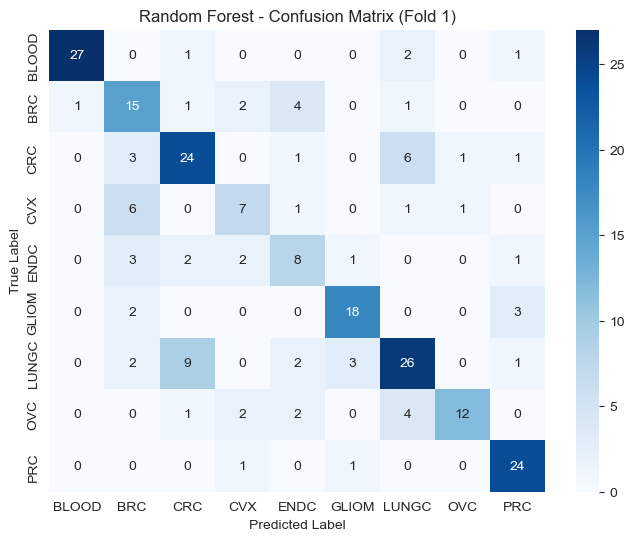

Fold 2 - Accuracy: 0.6102, F1: 0.6069, ROC AUC: 0.9034


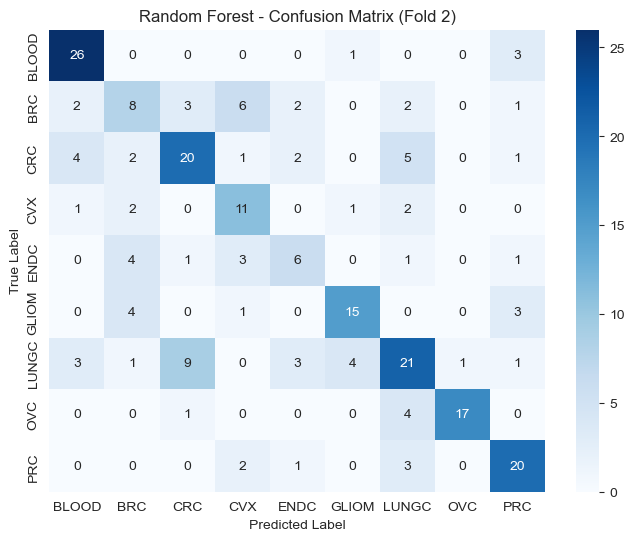

Fold 3 - Accuracy: 0.6737, F1: 0.6758, ROC AUC: 0.9245


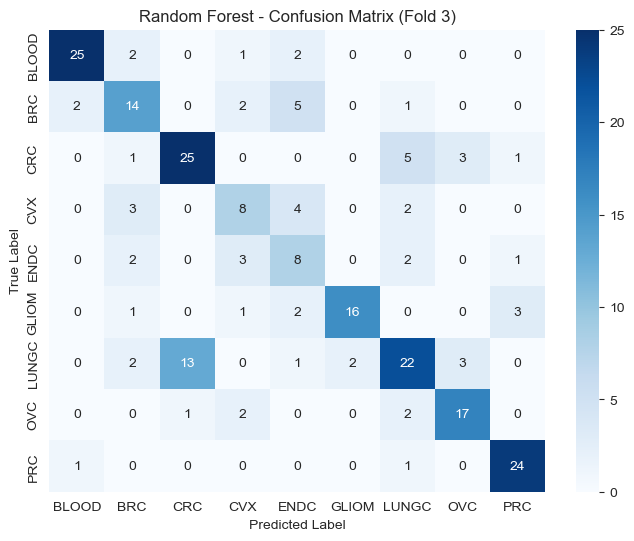

Fold 4 - Accuracy: 0.6483, F1: 0.6460, ROC AUC: 0.9136


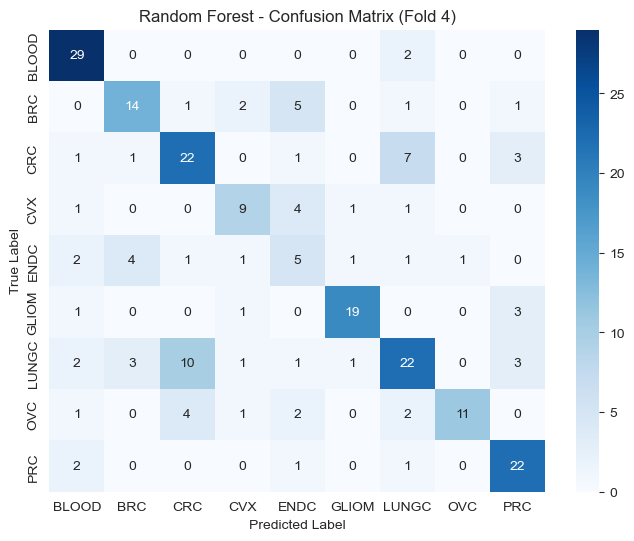

Fold 5 - Accuracy: 0.6525, F1: 0.6588, ROC AUC: 0.9192


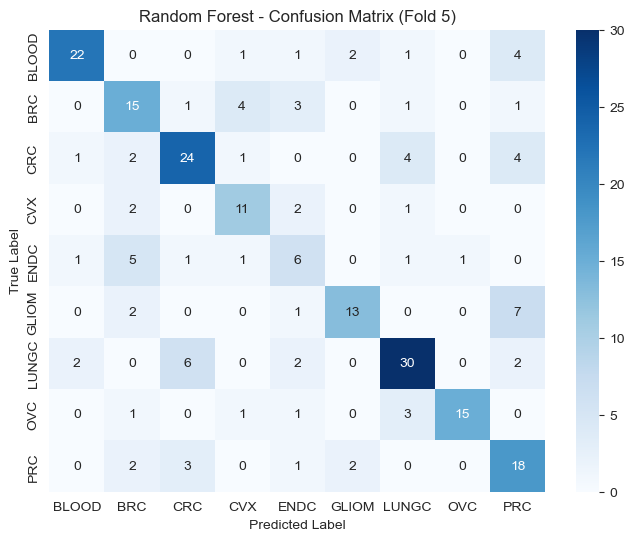


Random Forest - Mean Accuracy: 0.6528 ± 0.0239
Random Forest - Mean F1 Score: 0.6536
Random Forest - Mean ROC AUC: 0.9189

Evaluating Extra Trees full pancancer dataset with all 1463 proteins (combined BLOOD)
Fold 1 - Accuracy: 0.6203, F1: 0.6226, ROC AUC: 0.9043


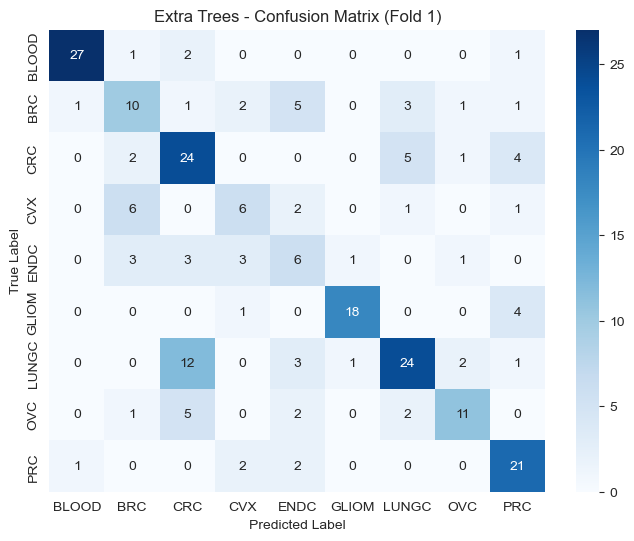

Fold 2 - Accuracy: 0.5890, F1: 0.5873, ROC AUC: 0.8858


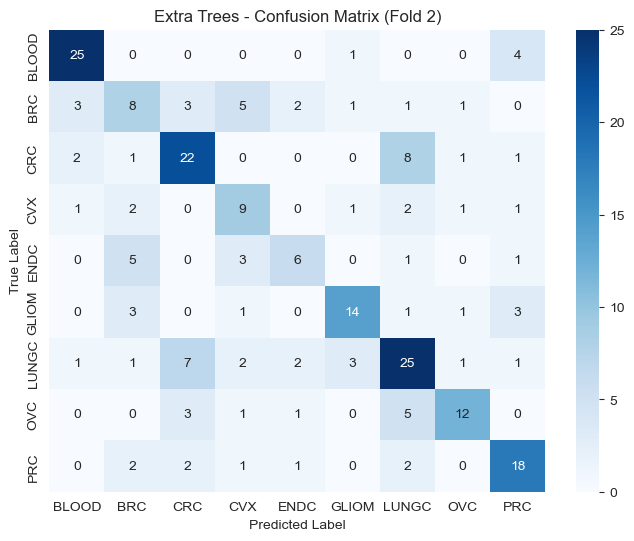

Fold 3 - Accuracy: 0.6144, F1: 0.6162, ROC AUC: 0.9182


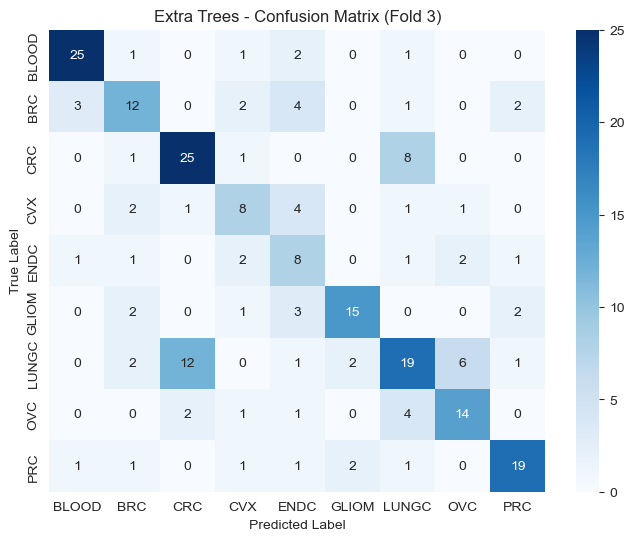

Fold 4 - Accuracy: 0.6059, F1: 0.6105, ROC AUC: 0.9002


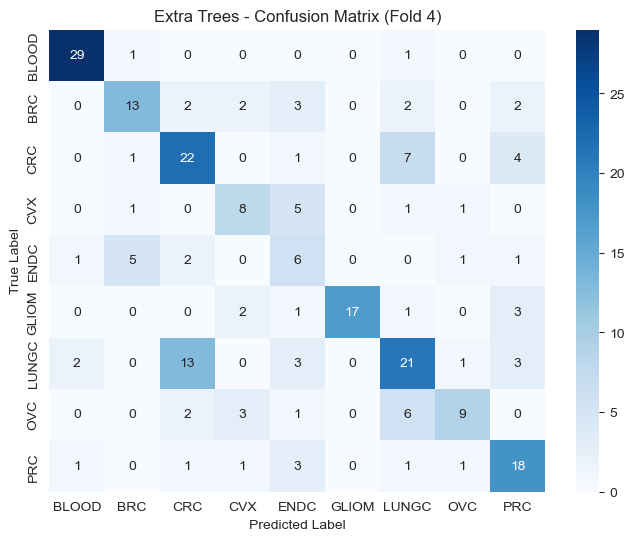

Fold 5 - Accuracy: 0.6186, F1: 0.6227, ROC AUC: 0.9060


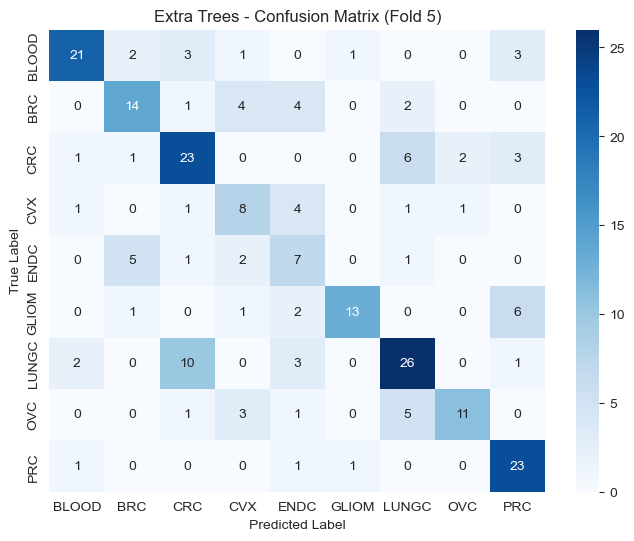


Extra Trees - Mean Accuracy: 0.6096 ± 0.0112
Extra Trees - Mean F1 Score: 0.6119
Extra Trees - Mean ROC AUC: 0.9029

Final Test Accuracy: 0.6689
Final Test F1 Score: 0.6695
Final Test ROC AUC: 0.9224


In [29]:
from imblearn.pipeline import Pipeline  # Use imblearn's pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import numpy as np
from scipy.stats import sem

# Assuming X_train, y_train, X_test, and y_test are already defined

# Define the models to loop over
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=100),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=100)
}

# k-Fold Cross-Validation Setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

# Loop over models
for model_name, model in models.items():
    print(f"\033[1m\nEvaluating {model_name} full pancancer dataset with all 1463 proteins (combined BLOOD)\033[0m")

    # Container for metrics
    fold_accuracies = []
    fold_f1_scores = []
    fold_roc_auc_scores = []
    fold_confusion_matrices = []

    # k-Fold Cross-Validation Loop
    for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        # Extract train and test sets for the current fold
        X_fold_train = X_train.iloc[train_index]
        X_fold_test = X_train.iloc[test_index]
        y_fold_train = y_train.iloc[train_index]
        y_fold_test = y_train.iloc[test_index]

        # Create the pipeline: Imputation -> SMOTE -> Classifier
        pipeline = Pipeline([
            ('imputer', KNNImputer(n_neighbors=5, weights="uniform")),  # kNN Imputation
            ('smote', SMOTE(random_state=100)),                        # SMOTE
            ('classifier', model)                                       # Model
        ])
        
        # Fit and evaluate the model within the pipeline
        pipeline.fit(X_fold_train, y_fold_train)

        # Predict and evaluate metrics for this fold
        y_pred = pipeline.predict(X_fold_test)
        fold_accuracies.append(accuracy_score(y_fold_test, y_pred))
        fold_f1_scores.append(f1_score(y_fold_test, y_pred, average='weighted'))
        fold_roc_auc_scores.append(roc_auc_score(y_fold_test, pipeline.predict_proba(X_fold_test), multi_class='ovr'))
        fold_confusion_matrices.append(confusion_matrix(y_fold_test, y_pred))

        # Print accuracy and other metrics for this fold
        print(f"Fold {i+1} - Accuracy: {fold_accuracies[-1]:.4f}, F1: {fold_f1_scores[-1]:.4f}, ROC AUC: {fold_roc_auc_scores[-1]:.4f}")
  
        ## Optionally plot the confusion matrix for the last fold
        plt.figure(figsize=(8, 6))
        sns.heatmap(fold_confusion_matrices[-1], annot=True, fmt='d', cmap='Blues', 
                    xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f"{model_name} - Confusion Matrix (Fold {i+1})")
        plt.show()
    
    
    # Display averaged accuracy and metrics for the cross-validation
    mean_accuracy = np.mean(fold_accuracies)
    mean_f1_score = np.mean(fold_f1_scores)
    mean_roc_auc = np.mean(fold_roc_auc_scores)
    confidence_interval = 1.96 * sem(fold_accuracies)
    
    print(f"\n{model_name} - Mean Accuracy: {mean_accuracy:.4f} ± {confidence_interval:.4f}")
    print(f"{model_name} - Mean F1 Score: {mean_f1_score:.4f}")
    print(f"{model_name} - Mean ROC AUC: {mean_roc_auc:.4f}")



# After cross-validation, impute on the entire training and test set and train the best model

# Assuming the best model was Random Forest (or another model if selected)
best_model = RandomForestClassifier(n_estimators=100, random_state=100)

# Create the pipeline for final training
pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5, weights="uniform")),
    ('smote', SMOTE(random_state=100)),
    ('classifier', best_model)
])

# Fit the pipeline on the entire training set
pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_test_pred = pipeline.predict(X_test)

# Evaluate final performance metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred, average='weighted')
test_roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test), multi_class='ovr')

print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test F1 Score: {test_f1_score:.4f}")
print(f"Final Test ROC AUC: {test_roc_auc:.4f}")


In [26]:
from imblearn.pipeline import Pipeline  # Use imblearn's pipeline instead of sklearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import numpy as np

# Assuming X_train (features) and y_train (target) are defined

# Define the models to loop over
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=100),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=100)
}

# Container for storing metrics across models
all_metrics = {}

# Loop over models
for model_name, model in models.items():
    print(f"\033[1m\nEvaluating {model_name} for the pancancer dataset with top 500 features (combined BLOOD)\033[0m")

    # Create a pipeline (imputation + classifier)
    pipeline = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5, weights="uniform")),  # Imputation step
        ('smote', SMOTE(random_state=100)),  # SMOTE for balancing classes
        ('classifier', model)  # Classifier (Random Forest or Extra Trees)
    ])

    # 3. Perform Stratified k-Fold Cross-Validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

    # Lists to store the metrics for each fold
    fold_accuracies = []
    fold_f1_scores = []
    fold_roc_auc_scores = []

    # Cross-validation loop
    for fold, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):

        # Split the data into train and test sets for the current fold
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        # Create a pipeline for each fold with imputation, SMOTE, and model
        pipeline_fold = Pipeline([
            ('imputer', KNNImputer(n_neighbors=5, weights="uniform")),  # Imputation
            ('smote', SMOTE(random_state=100)),  # SMOTE
            ('classifier', model)  # Model (Random Forest or Extra Trees)
        ])

        # Train the model on the current fold
        pipeline_fold.fit(X_fold_train, y_fold_train)

        # Access the trained model's feature importances for this fold
        feature_importances = pipeline_fold.named_steps['classifier'].feature_importances_

        # 2. Select the top 500 features based on feature importance for this fold
        top_500_features_idx = np.argsort(feature_importances)[::-1][:500]  # Sort descending and pick top 500
        top_500_features = X_fold_train.columns[top_500_features_idx]  # Feature names for top 500

        # Create a new feature matrix with only the top 500 features for both train and test
        X_fold_train_top_500 = X_fold_train.iloc[:, top_500_features_idx]
        X_fold_test_top_500 = X_fold_test.iloc[:, top_500_features_idx]

        # Train the model again on the top 500 features for the current fold
        pipeline_fold.fit(X_fold_train_top_500, y_fold_train)

        # Predict on the test fold
        y_pred = pipeline_fold.predict(X_fold_test_top_500)

        # Calculate metrics for this fold
        fold_accuracies.append(accuracy_score(y_fold_test, y_pred))
        fold_f1_scores.append(f1_score(y_fold_test, y_pred, average='weighted'))
        fold_roc_auc_scores.append(roc_auc_score(y_fold_test, pipeline_fold.predict_proba(X_fold_test_top_500), multi_class='ovr'))

        # Print the metrics for the current fold
        print(f"Fold {fold + 1} - Accuracy: {fold_accuracies[-1]:.4f}, F1 Score: {fold_f1_scores[-1]:.4f}, ROC AUC: {fold_roc_auc_scores[-1]:.4f}")

    # 4. Display averaged metrics and standard deviation across folds
    mean_accuracy = np.mean(fold_accuracies)
    std_accuracy = np.std(fold_accuracies)
    mean_f1_score = np.mean(fold_f1_scores)
    std_f1_score = np.std(fold_f1_scores)
    mean_roc_auc = np.mean(fold_roc_auc_scores)
    std_roc_auc = np.std(fold_roc_auc_scores)

    # Store metrics for the model
    all_metrics[model_name] = {
        'Mean Accuracy': mean_accuracy,
        'Std Accuracy': std_accuracy,
        'Mean F1 Score': mean_f1_score,
        'Std F1 Score': std_f1_score,
        'Mean ROC AUC': mean_roc_auc,
        'Std ROC AUC': std_roc_auc
    }

    # Print the Final Results message in bold
    print("\033[1m\n--- Final Results (Top 500 Features) ---\033[0m")
    print(f"{model_name} - Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"{model_name} - Mean F1 Score: {mean_f1_score:.4f} ± {std_f1_score:.4f}")
    print(f"{model_name} - Mean ROC AUC: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")

# Display all metrics for each model after the loop
print("\033[1m\n--- All Model Metrics ---\033[0m")
for model_name, metrics in all_metrics.items():
    print(f"{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")



Evaluating Random Forest for the pancancer dataset with top 500 features (combined BLOOD)
Fold 1 - Accuracy: 0.7511, F1 Score: 0.7517, ROC AUC: 0.9383
Fold 2 - Accuracy: 0.6398, F1 Score: 0.6367, ROC AUC: 0.9130
Fold 3 - Accuracy: 0.7246, F1 Score: 0.7301, ROC AUC: 0.9348
Fold 4 - Accuracy: 0.6949, F1 Score: 0.6967, ROC AUC: 0.9230
Fold 5 - Accuracy: 0.6992, F1 Score: 0.6975, ROC AUC: 0.9389

--- Final Results (Top 500 Features) ---
Random Forest - Mean Accuracy: 0.7019 ± 0.0370
Random Forest - Mean F1 Score: 0.7026 ± 0.0389
Random Forest - Mean ROC AUC: 0.9296 ± 0.0101

Evaluating Extra Trees for the pancancer dataset with top 500 features (combined BLOOD)
Fold 1 - Accuracy: 0.6793, F1 Score: 0.6811, ROC AUC: 0.9284
Fold 2 - Accuracy: 0.6144, F1 Score: 0.6139, ROC AUC: 0.8956
Fold 3 - Accuracy: 0.6992, F1 Score: 0.7033, ROC AUC: 0.9328
Fold 4 - Accuracy: 0.6186, F1 Score: 0.6190, ROC AUC: 0.9149
Fold 5 - Accuracy: 0.6780, F1 Score: 0.6799, ROC AUC: 0.9207

--- Final Results (Top 500 

In [25]:
from imblearn.pipeline import Pipeline  # Use imblearn's pipeline instead of sklearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import numpy as np

# Assuming X_train (features) and y_train (target) are defined

# Define the models to loop over
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=100),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=100)
}

# Container for storing metrics across models
all_metrics = {}

# Loop over models
for model_name, model in models.items():
    print(f"\033[1m\nEvaluating {model_name} for the pancancer dataset with top 100 features (combined BLOOD)\033[0m")

    # Create a pipeline (imputation + classifier)
    pipeline = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5, weights="uniform")),  # Imputation step
        ('smote', SMOTE(random_state=100)),  # SMOTE for balancing classes
        ('classifier', model)  # Classifier (Random Forest or Extra Trees)
    ])

    # 3. Perform Stratified k-Fold Cross-Validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

    # Lists to store the metrics for each fold
    fold_accuracies = []
    fold_f1_scores = []
    fold_roc_auc_scores = []
    fold_confusion_matrices = []  # This needs to be initialized before the fold loop

    # Cross-validation loop
    for fold, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):

        # Split the data into train and test sets for the current fold
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        # Create a pipeline for each fold with imputation, SMOTE, and model
        pipeline_fold = Pipeline([
            ('imputer', KNNImputer(n_neighbors=5, weights="uniform")),  # Imputation
            ('smote', SMOTE(random_state=100)),  # SMOTE
            ('classifier', model)  # Model (Random Forest or Extra Trees)
        ])

        # Train the model on the current fold
        pipeline_fold.fit(X_fold_train, y_fold_train)

        # Access the trained model's feature importances for this fold
        feature_importances = pipeline_fold.named_steps['classifier'].feature_importances_

        # 2. Select the top 100 features based on feature importance for this fold
        top_100_features_idx = np.argsort(feature_importances)[::-1][:100]  # Sort descending and pick top 100
        top_100_features = X_fold_train.columns[top_100_features_idx]  # Feature names for top 100

        # Create a new feature matrix with only the top 100 features for both train and test
        X_fold_train_top_100 = X_fold_train.iloc[:, top_100_features_idx]
        X_fold_test_top_100 = X_fold_test.iloc[:, top_100_features_idx]

        # Train the model again on the top 100 features for the current fold
        pipeline_fold.fit(X_fold_train_top_100, y_fold_train)

        # Predict on the test fold
        y_pred = pipeline_fold.predict(X_fold_test_top_100)

        # Calculate metrics for this fold
        fold_accuracies.append(accuracy_score(y_fold_test, y_pred))
        fold_f1_scores.append(f1_score(y_fold_test, y_pred, average='weighted'))
        fold_roc_auc_scores.append(roc_auc_score(y_fold_test, pipeline_fold.predict_proba(X_fold_test_top_100), multi_class='ovr'))

        # Calculate and append confusion matrix for this fold
        fold_conf_matrix = confusion_matrix(y_fold_test, y_pred)
        fold_confusion_matrices.append(fold_conf_matrix)
        
        # Print the metrics for the current fold
        print(f"Fold {fold + 1} - Accuracy: {fold_accuracies[-1]:.4f}, F1 Score: {fold_f1_scores[-1]:.4f}, ROC AUC: {fold_roc_auc_scores[-1]:.4f}")

    # 4. Display averaged metrics and standard deviation across folds
    mean_accuracy = np.mean(fold_accuracies)
    std_accuracy = np.std(fold_accuracies)
    mean_f1_score = np.mean(fold_f1_scores)
    std_f1_score = np.std(fold_f1_scores)
    mean_roc_auc = np.mean(fold_roc_auc_scores)
    std_roc_auc = np.std(fold_roc_auc_scores)

    # Store metrics for the model
    all_metrics[model_name] = {
        'Mean Accuracy': mean_accuracy,
        'Std Accuracy': std_accuracy,
        'Mean F1 Score': mean_f1_score,
        'Std F1 Score': std_f1_score,
        'Mean ROC AUC': mean_roc_auc,
        'Std ROC AUC': std_roc_auc
    }

    # Print the Final Results message in bold
    print("\033[1m\n--- Final Results (Top 100 Features) ---\033[0m")
    print(f"{model_name} - Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"{model_name} - Mean F1 Score: {mean_f1_score:.4f} ± {std_f1_score:.4f}")
    print(f"{model_name} - Mean ROC AUC: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")

# Display all metrics for each model after the loop
print("\n--- All Model Metrics ---")
for model_name, metrics in all_metrics.items():
    print(f"{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")



Evaluating Random Forest for the pancancer dataset with top 100 features (combined BLOOD)
Fold 1 - Accuracy: 0.7384, F1 Score: 0.7407, ROC AUC: 0.9497
Fold 2 - Accuracy: 0.6653, F1 Score: 0.6651, ROC AUC: 0.9214
Fold 3 - Accuracy: 0.7373, F1 Score: 0.7378, ROC AUC: 0.9484
Fold 4 - Accuracy: 0.6949, F1 Score: 0.6947, ROC AUC: 0.9360
Fold 5 - Accuracy: 0.6949, F1 Score: 0.6957, ROC AUC: 0.9345

--- Final Results (Top 100 Features) ---
Random Forest - Mean Accuracy: 0.7062 ± 0.0281
Random Forest - Mean F1 Score: 0.7068 ± 0.0287
Random Forest - Mean ROC AUC: 0.9380 ± 0.0104

Evaluating Extra Trees for the pancancer dataset with top 100 features (combined BLOOD)
Fold 1 - Accuracy: 0.7257, F1 Score: 0.7285, ROC AUC: 0.9411
Fold 2 - Accuracy: 0.6653, F1 Score: 0.6656, ROC AUC: 0.9257
Fold 3 - Accuracy: 0.7119, F1 Score: 0.7165, ROC AUC: 0.9458
Fold 4 - Accuracy: 0.6992, F1 Score: 0.6982, ROC AUC: 0.9294
Fold 5 - Accuracy: 0.6780, F1 Score: 0.6768, ROC AUC: 0.9323

--- Final Results (Top 100 

In [22]:
from imblearn.pipeline import Pipeline  # Use imblearn's pipeline instead of sklearn
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

# Assuming X_train (features) and y_train (target) are defined

# Define the models to loop over
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=100),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=100)
}

# Container for storing metrics across models
all_metrics = {}

# Loop over models
for model_name, model in models.items():
    print(f"\033[1m\nEvaluating {model_name} for the pancancer dataset with top 50 features (combined BLOOD)\033[0m")

    # 1. Stratified k-Fold Cross-Validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

    # Lists to store the metrics for each fold
    fold_accuracies = []
    fold_f1_scores = []
    fold_roc_auc_scores = []
    fold_confusion_matrices = []  # This needs to be initialized before the fold loop

    # Cross-validation loop
    for fold, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):

        # Split the data into train and test sets for the current fold
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        # Create a pipeline for each fold with imputation and SMOTE
        pipeline_fold = Pipeline([
            ('imputer', KNNImputer(n_neighbors=5, weights="uniform")),  # Imputation
            ('smote', SMOTE(random_state=100)),  # SMOTE
            ('classifier', model)  # Model (Random Forest or Extra Trees)
        ])

        # Train the model on the current fold
        pipeline_fold.fit(X_fold_train, y_fold_train)

        # Access the trained model's feature importances for this fold
        feature_importances = pipeline_fold.named_steps['classifier'].feature_importances_

        # 2. Select the top 50 features based on feature importance for this fold
        top_50_features_idx = np.argsort(feature_importances)[::-1][:50]  # Sort descending and pick top 50
        top_50_features = X_fold_train.columns[top_50_features_idx]  # Feature names for top 50

        # Create a new feature matrix with only the top 50 features
        X_fold_train_top_50 = X_fold_train.iloc[:, top_50_features_idx]
        X_fold_test_top_50 = X_fold_test.iloc[:, top_50_features_idx]

        # Train the model again on the top 50 features for the current fold
        pipeline_fold.fit(X_fold_train_top_50, y_fold_train)

        # Predict on the test fold
        y_pred = pipeline_fold.predict(X_fold_test_top_50)

        # Calculate metrics for this fold
        fold_accuracies.append(accuracy_score(y_fold_test, y_pred))
        fold_f1_scores.append(f1_score(y_fold_test, y_pred, average='weighted'))
        fold_roc_auc_scores.append(roc_auc_score(y_fold_test, pipeline_fold.predict_proba(X_fold_test_top_50), multi_class='ovr'))

        # Calculate and append confusion matrix for this fold
        fold_conf_matrix = confusion_matrix(y_fold_test, y_pred)
        fold_confusion_matrices.append(fold_conf_matrix)
        
        # Print the metrics for the current fold
        print(f"Fold {fold + 1} - Accuracy: {fold_accuracies[-1]:.4f}, F1 Score: {fold_f1_scores[-1]:.4f}, ROC AUC: {fold_roc_auc_scores[-1]:.4f}")

    # 3. Display averaged metrics and standard deviation across folds
    mean_accuracy = np.mean(fold_accuracies)
    std_accuracy = np.std(fold_accuracies)
    mean_f1_score = np.mean(fold_f1_scores)
    std_f1_score = np.std(fold_f1_scores)
    mean_roc_auc = np.mean(fold_roc_auc_scores)
    std_roc_auc = np.std(fold_roc_auc_scores)

    # Store metrics for the model
    all_metrics[model_name] = {
        'Mean Accuracy': mean_accuracy,
        'Std Accuracy': std_accuracy,
        'Mean F1 Score': mean_f1_score,
        'Std F1 Score': std_f1_score,
        'Mean ROC AUC': mean_roc_auc,
        'Std ROC AUC': std_roc_auc
    }

    # Print the Final Results message in bold
    print("\033[1m\n--- Final Results (Top 50 Features for each fold) ---\033[0m")
    print(f"{model_name} - Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"{model_name} - Mean F1 Score: {mean_f1_score:.4f} ± {std_f1_score:.4f}")
    print(f"{model_name} - Mean ROC AUC: {mean_roc_auc:.4f} ± {std_roc_auc:.4f}")
    
    # Optionally, you can visualize the performance metrics across folds for each model
    # Plot accuracy across folds
    # plt.plot(range(1, len(fold_accuracies) + 1), fold_accuracies, label=f'{model_name} Accuracy')
    # plt.xlabel('Fold')
    # plt.ylabel('Accuracy')
    # plt.title(f'Accuracy Across Folds - {model_name}')
    # plt.legend()
    # plt.show()

# Display all metrics for each model after the loop
print("\n--- All Model Metrics ---")
for model_name, metrics in all_metrics.items():
    print(f"{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")



Evaluating Random Forest for the pancancer dataset with top 50 features (combined BLOOD)
Fold 1 - Accuracy: 0.7089, F1 Score: 0.7108, ROC AUC: 0.9437
Fold 2 - Accuracy: 0.6356, F1 Score: 0.6365, ROC AUC: 0.9235
Fold 3 - Accuracy: 0.6822, F1 Score: 0.6840, ROC AUC: 0.9394
Fold 4 - Accuracy: 0.7119, F1 Score: 0.7111, ROC AUC: 0.9332
Fold 5 - Accuracy: 0.6525, F1 Score: 0.6556, ROC AUC: 0.9335

--- Final Results (Top 50 Features for each fold) ---
Random Forest - Mean Accuracy: 0.6782 ± 0.0302
Random Forest - Mean F1 Score: 0.6796 ± 0.0297
Random Forest - Mean ROC AUC: 0.9347 ± 0.0068

Evaluating Extra Trees for the pancancer dataset with top 50 features (combined BLOOD)
Fold 1 - Accuracy: 0.7004, F1 Score: 0.7012, ROC AUC: 0.9417
Fold 2 - Accuracy: 0.6737, F1 Score: 0.6751, ROC AUC: 0.9288
Fold 3 - Accuracy: 0.7161, F1 Score: 0.7178, ROC AUC: 0.9359
Fold 4 - Accuracy: 0.6653, F1 Score: 0.6629, ROC AUC: 0.9311
Fold 5 - Accuracy: 0.6483, F1 Score: 0.6515, ROC AUC: 0.9269

--- Final Result